In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment
from gillespy2 import ODECSolver, ODESolver, SSACSolver

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from scipy import stats

# devils Parameter Approximation

This notebook is used to calibrate a initial values which approximately match the results given in Cunningham, Calum X., et al. "Quantifying 25 years of disease‐caused declines in Tasmanian devil populations: host density drives spatial pathogen spread." Ecology Letters 24.5 (2021): 958-969. The objective of this notebook is to gain an "eyeball approximation" of reasonable starting values to serve as input for more sophisticated inferencing.

## Read in observed data

In [2]:
# pop_data = pd.read_csv('../year_data/devil_data_v2.csv')
pop_data = pd.read_csv('month_data/Devils_Dataset__Population_1985-2020.csv')

devil_pop = np.array(pop_data['Population'].iloc[:].values)

obs = np.vstack([devil_pop]).reshape(1, 1, -1)
# print(obs)

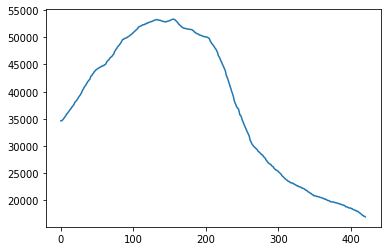

In [3]:
plt.plot(range(0,len(devil_pop)), devil_pop)

## Model

In [4]:
variables = {
    "r": "0.029",
    "ds": "0.0048",
    "dI": "0.044",
    "L": "27.39",
    "k0": "0.48"
}

In [5]:
class Devilsv101(Model):
    def __init__(self, values=None, events=None):
        Model.__init__(self, name="devils_v1.0")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="r", expression=values['r']))
        self.add_parameter(Parameter(name="K", expression=max(devil_pop)*1.16))
        self.add_parameter(Parameter(name="ds", expression=values['ds']))
        self.add_parameter(Parameter(name="dI", expression=values['dI']))
        self.add_parameter(Parameter(name="L", expression=values['L']))
        self.add_parameter(Parameter(name="k0", expression=values['k0']))

        # Variables (initial values adjusted to observed data)
        self.add_species(Species(name="S", initial_value=round(devil_pop[0]), mode="discrete"))
        self.add_species(Species(name="E", initial_value=0, mode="discrete"))
        self.add_species(Species(name="I", initial_value=0, mode="discrete"))
        self.add_species(Species(name="Devils", initial_value=round(devil_pop[0]), mode="discrete"))

        # Reactions
        self.add_reaction(Reaction(name="birth", reactants={}, products={'S': 1, 'Devils': 1}, propensity_function="r*(S+E+I)*(1-(S+E+I)/K)"))
        self.add_reaction(Reaction(name="death_S", reactants={'S': 1, 'Devils': 1}, products={}, propensity_function="ds*S"))
        self.add_reaction(Reaction(name="transmission", reactants={'S': 1, 'I': 1}, products={'E': 1, 'I':1}, propensity_function="k0*S*I/K"))
        self.add_reaction(Reaction(name="death_E", reactants={'Devils': 1, 'E': 1}, products={}, propensity_function="ds*E"))
        self.add_reaction(Reaction(name="latency", reactants={'E': 1}, products={'I': 1}, propensity_function="E/L"))
        self.add_reaction(Reaction(name="death_I", reactants={'I': 1, 'Devils': 1}, products={}, propensity_function="dI*I"))

        # Events
        if events is not None:
            self.add_event(events)
        
        # Timespan
        self.timespan(np.arange(0, 422, 1)) # month data tspan

In [6]:
def run_current_model():
    trigger = EventTrigger(expression="t >= 132")
    assignments = [
        EventAssignment(variable="I", expression="round(S * 0.001)"),
        EventAssignment(variable="S", expression="round(S * 0.999)")
    ]
    dftd = Event(name="dftd", assignments=assignments, trigger=trigger)
    e_model = Devilsv101(values=variables, events=[dftd])
    
    results = e_model.run()
    
    print(stats.kstest(rvs=results['Devils'], cdf=devil_pop))
    
    obs_trace = go.Scatter(
        x = results['time'],
        y = obs[0][0],
        mode = "lines",
        line = {"color": "black", "dash": "dash"},
        name = "Observed Data",
        legendgroup = "Observed Data"
    )
    fig = results.plotplotly(return_plotly_figure=True)
    fig['data'].insert(0, obs_trace)
    iplot(fig)

In [7]:
run_current_model()

KstestResult(statistic=0.24703087885985747, pvalue=8.811840146449867e-12)


In [8]:
model = Devilsv101(values=variables)
# print(model)

In [9]:
solver = SSACSolver(model, variable=True)

## Configure Solver Widgets

In [10]:
def pre_infection(start, end, birth, S_death):
    print('=================================')
    print(f'| Time Range: {start}-{end}')
    print('| -------------------------------')
    print('| Input Parameters:')
    print(f'| \tr: {birth}')
    print(f'| \tds: {S_death}')
    print('| -------------------------------')
    print(f'| Initial Value of Devils: {round(devil_pop[start])}')
    print('| -------------------------------')
    
    model.listOfSpecies['Devils'].initial_value = round(devil_pop[start])
    model.listOfSpecies['S'].initial_value = round(devil_pop[start])
    model.listOfSpecies['I'].initial_value = 0

    variables['r'] = str(birth)
    variables['ds'] = str(S_death)
    results = solver.run(
        model=model, variables=variables, t=end-start
    )
    
    total_devils = np.add(np.add(results['I'], results['S']), results['E'])
    ks_result = stats.kstest(rvs=total_devils, cdf=devil_pop)
    print('| KS Test Results:')
    print(f'| \tStatistic: {ks_result.statistic}')
    print(f'| \tP Value: {ks_result.pvalue}')
    
    title = f'Total Species for Time Range {start}-{end}'
    
    simulated_devils = plt.plot(range(start, end+1), total_devils, 'b', label='Simulated Total')
    s_devils = plt.plot(range(start, end+1), results['S'], 'g', alpha=.3, label='Susceptible')
    i_devils = plt.plot(range(start, end+1), results['I'], 'r', alpha=.3, label='Infected')
    e_devils = plt.plot(range(start, end+1), results['E'], 'y', alpha=.3, label='Exposed')
    expected_devils = plt.plot(range(start, end), devil_pop[start:end], '--b', label='Observed Total')
    plt.xlabel('month')
    plt.ylabel('population')
    plt.legend(loc='best')
    plt.title(title)
    
    print(f'| TOTAL Expected: {devil_pop[end-1]} - Got: {total_devils[-1]}')
    print('=================================')

In [11]:
def post_infection(start, end, birth, L, k0, S_death, I_death):
    concentration_i = 0.001
    S_pop = round(devil_pop[start] * (1-concentration_i))
    I_pop = round(devil_pop[start] * concentration_i)
    
    print('=================================')
    print(f'| Time Range: {start}-{end}')
    print('| -------------------------------')
    print('| Input Parameters:')
    print(f'| \tr: {birth}')
    print(f'| \tds: {S_death}')
    print(f'| \tL: {L}')
    print(f'| \tk0: {k0}')
    print(f'| \tdI: {I_death}')
    print('| -------------------------------')
    print(f'| Initial Value of Devils: {round(devil_pop[start])}')
    print(f'| Initial Value of S: {S_pop}')
    print(f'| Initial Value of I: {I_pop}')
    print('| -------------------------------')
    
    model.listOfSpecies['Devils'].initial_value = round(devil_pop[start])
    model.listOfSpecies['S'].initial_value = S_pop
    model.listOfSpecies['I'].initial_value = I_pop
    
    variables['r'] = str(birth)
    variables['ds'] = str(S_death)
    variables['L'] = str(L)
    variables['k0'] = str(k0)
    variables['dI'] = str(I_death)
    results = solver.run(
        model=model, variables=variables, t=end-start
    )
    
    total_devils = np.add(np.add(results['I'], results['S']), results['E'])
    ks_result = stats.kstest(rvs=total_devils, cdf=devil_pop)
    print('| KS Test Results:')
    print(f'| \tStatistic: {ks_result.statistic}')
    print(f'| \tP Value: {ks_result.pvalue}')
    
    title = f'Total Species for Time Range {start}-{end}'
    
    simulated_devils = plt.plot(range(start, end+1), total_devils, 'b', label='Simulated Total')
    s_devils = plt.plot(range(start, end+1), results['S'], 'g', alpha=.3, label='Susceptible')
    i_devils = plt.plot(range(start, end+1), results['I'], 'r', alpha=.3, label='Infected')
    e_devils = plt.plot(range(start, end+1), results['E'], 'y', alpha=.3, label='Exposed')
    expected_devils = plt.plot(range(start, end), devil_pop[start:end], '--b', label='Observed Total')
    plt.xlabel('month')
    plt.ylabel('population')
    plt.legend(loc='best')
    plt.title(title)
    
    print(f'| TOTAL Expected: {devil_pop[end-1]} - Got: {total_devils[-1]}')
    print('=================================')

## Create Widgets

## Calibrate Pre-Infection Model

### Create Widgets

In [12]:
month = 12
bi_widgets = {
    "start": widgets.IntSlider(min=0, max=131, step=1, value=0),
    "end": widgets.IntSlider(min=1, max=132, step=1, value=132),
    "birth": widgets.FloatSlider(min=0, max=1/month, step=0.001, value=.029),
    "S_death": widgets.FloatSlider(min=0, max=.01, step=.0001, value=.0058)
}

### Run widgets and attempt to calibrate model

In [13]:
interact(pre_infection, **bi_widgets)

interactive(children=(IntSlider(value=0, description='start', max=131), IntSlider(value=132, description='end'…

<function __main__.pre_infection(start, end, birth, S_death)>

## Calibrate Post-Infection Model

### Create Widgets

In [14]:
ai_widgets = {
    "start": widgets.IntSlider(min=132, max=420, step=1, value=132),
    "end": widgets.IntSlider(min=133, max=421, step=1, value=421),
    "birth": widgets.FloatSlider(min=0, max=1/month, step=0.001, value=variables['r']),
    "L": widgets.FloatSlider(min=0, max=100, step=0.01, value=variables['L']),
    "k0": widgets.FloatSlider(min=0, max=2, step=0.01, value=variables['k0']),
    "S_death": widgets.FloatSlider(min=0.0028, max=.0074, step=.0001, value=variables['ds']),
    "I_death": widgets.FloatSlider(min=0, max=.1, step=.001, value=variables['dI'])
}

### Run the widgets and attempt to calibrate model

In [15]:
interact(post_infection, **ai_widgets)

interactive(children=(IntSlider(value=132, description='start', max=420, min=132), IntSlider(value=421, descri…

<function __main__.post_infection(start, end, birth, L, k0, S_death, I_death)>